# Mel Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [2]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [231]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="float32")
white = np.array(white, dtype="float32")

clean_dataset = []
white_dataset = []

samples_length = nperseg*5

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

In [232]:
spectrogram_clean_dataset = []
spectrogram_white_dataset = []
spectrogram_clean_dataset_imag = []
spectrogram_white_dataset_imag = []

for sample in clean_dataset:
    spectrogram_clean_dataset.append(np.abs(librosa.stft(sample))[1:])
    spectrogram_clean_dataset_imag.append(np.imag(librosa.stft(sample))[1:])
for sample in white_dataset:
    spectrogram_white_dataset.append(np.abs(librosa.stft(sample))[1:])
    spectrogram_white_dataset_imag.append(np.imag(librosa.stft(sample))[1:])

spectrogram_clean_dataset = np.array(spectrogram_clean_dataset)
spectrogram_white_dataset = np.array(spectrogram_white_dataset)

max_clean = np.max(spectrogram_clean_dataset)
min_clean = np.min(spectrogram_clean_dataset)
spectrogram_clean_dataset = (spectrogram_clean_dataset-min_clean)/max_clean

max_white = np.max(spectrogram_white_dataset)
min_white = np.min(spectrogram_white_dataset)
spectrogram_white_dataset = (spectrogram_white_dataset-min_white)/max_white

In [233]:
data_shape = (spectrogram_white_dataset.shape[1:])

In [234]:
print("Data shape:", data_shape)
print("Dataset shape:", spectrogram_white_dataset.shape)

Data shape: (1024, 11)
Dataset shape: (2131, 1024, 11)


In [235]:
print(np.max(np.abs(spectrogram_clean_dataset)), np.max(np.abs(spectrogram_white_dataset)))

1.0 1.0


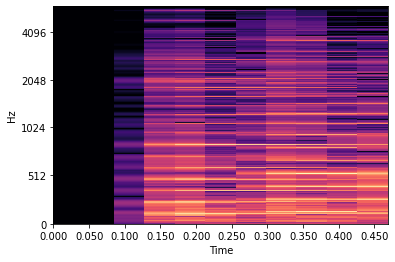

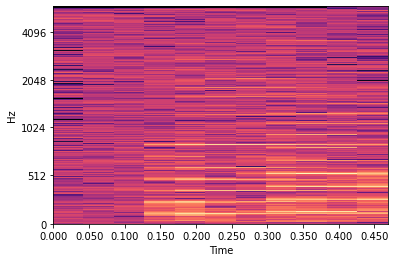

In [249]:
def view_input(dataset, i=0):
    pred = ((dataset[i])*max_clean)+min_clean
    S_dB = librosa.amplitude_to_db(pred, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=samplerate)
    plt.show()
    
def view_output(dataset, g, p, i=0):
    y = np.reshape(dataset[i], (-1, dataset.shape[1], dataset.shape[2]))
    array = gan.g.predict(y)
    pred = ((array[0, :, :])*max_clean)+min_clean
    S_dB = librosa.amplitude_to_db(pred, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=samplerate)
    #plt.show()
    plt.savefig(str(p)+".png", format='png')

def hear_output(dataset, gan, i=0):
    y = np.reshape(dataset[i], (-1, dataset.shape[1], dataset.shape[2]))
    array = gan.g.predict(y)
    pred = ((array[0, :, :])*max_clean)+min_clean
    output = librosa.istft(((pred+min_clean)*max_clean)+np.imag(dataset[i]))
    return output
    
view_input(spectrogram_clean_dataset)
view_input(spectrogram_white_dataset)

# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

A first model is saved in `'save2/gan_without_add'`. It does not have any add layer. It has been train on 3104 steps on 5000 samples of size 2048, visualizable in the folder `save2` gif.

A first model is saved in `'save2/gan_with_add'`. It does have an add layer. It has been train on 2475 steps on 10000 samples of size 1024, visualizable in the folder `save3` gif.

### Discriminator

The discriminator here uses a layer to process the Short-Time Fourier Transform (https://en.wikipedia.org/wiki/Short-time_Fourier_transform) before reducing the problem dimension to one single boolean prediction layer.

Interestingly, adding a Dropout layer on the input seems to prevent the generator to adapt itself to the little flaws of detection (which then only produces noise unrecognized by the discriminator).

In [269]:
def discriminator(input_shape):
    inputs = tf.keras.Input(shape=(input_shape[1], input_shape[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    x1 = tf.keras.layers.Convolution1D(10, kernel_size=(4), activation="tanh", padding="same")(x)
    x2 = tf.keras.layers.MaxPooling1D()(x1)
    x3 = tf.keras.layers.Convolution1D(10, kernel_size=(4), activation="tanh", padding="same")(x2)
    x4 = tf.keras.layers.MaxPooling1D()(x3)
    x5 = tf.keras.layers.Convolution1D(10, kernel_size=(4), activation="tanh", padding="same")(x4)
    x6 = tf.keras.layers.MaxPooling1D()(x5)
    x7 = tf.keras.layers.Dense(1, activation="tanh")(x6)
    x8 = tf.keras.layers.Flatten()(x7)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x8)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
    return model

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [354]:
def generator(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    x1 = tf.keras.layers.Convolution1D(10, kernel_size=(4), activation="tanh", padding="same")(x)
    x2 = tf.keras.layers.MaxPooling1D()(x1)
    x3 = tf.keras.layers.Convolution1D(5, kernel_size=(4), activation="tanh", padding="same")(x2)
    x4 = tf.keras.layers.MaxPooling1D()(x3)
    x41 = tf.keras.layers.Convolution1D(5, kernel_size=(4), activation="tanh", padding="same")(x2)
    x5 = tf.keras.layers.MaxPooling1D()(x41)
    x51 = tf.keras.layers.Permute((2, 1))(x5)
    x52 = tf.keras.layers.Dense(128)(x51)
    x53 = tf.keras.layers.Permute((2, 1))(x52)
    x6 = tf.keras.layers.UpSampling1D()(x53)
    x7 = tf.keras.layers.UpSampling1D()(x6)
    x8 = tf.keras.layers.UpSampling1D()(x7)
    x9 = tf.keras.layers.Conv1DTranspose(10, kernel_size=(4), activation="tanh", padding="same")(x8)
    outputs = tf.keras.layers.Dense(sizes[2], activation='tanh')(x9)
    #outputs = tf.keras.layers.ReLU(max_value=1.)(x10)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model
g = generator(spectrogram_white_dataset.shape)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 1024, 11)]        0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 1024, 11)          0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 1024, 10)          450       
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 512, 10)           0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 512, 5)            205       
_________________________________________________________________
max_pooling1d_112 (MaxPoolin (None, 256, 5)            0         
_________________________________________________________________
permute_2 (Permute)          (None, 5, 256)            

In [336]:
def evaluate_generator(g, inputs, outputs, size=100):
    res = 0
    s = min(size, inputs.shape[0])
    for i in range(s):
        error = (g.predict(np.reshape(inputs[i], (-1, inputs[i].shape[0], inputs[i].shape[1])))-outputs[i])**2
        res += np.sum(error)
    return res/(s)

## Building the GAN

In [337]:
def get_generator_outputs(white, train_size, g, nperseg, clean):
    steps = train_size//20
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        if i%steps == 0:
            print("=", end='')
        t = np.reshape(white[i, :, :], (-1, white.shape[1], white.shape[2]))
        m = g.predict(t)
        g_outputs.append(m)
    print()
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1], white.shape[2]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((np.zeros((train_size,)), np.ones((train_size,))))
    return input_data, output_data

In [338]:
class GAN:
    def __init__(self, size, g, d):
        self.g = g
        self.d = d
        self.size = size
        self.build()
        
    def build(self):
        self.z = self.g.inputs
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(self.z, self.valid)
        self.compile()
        
    def block_discriminator(self):
        self.d.trainable = False
        self.g.trainable = True
        self.build()
        
    def block_generator(self):
        self.g.trainable = False
        self.d.trainable = True
        self.build()
        
    def compile(self):
        self.combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [339]:
def train_on_batch(d, i, o, validation_split=0, batch_size=16, verbose=True):
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [340]:
discriminator_train_size = (spectrogram_white_dataset.shape[0])
generator_train_size = spectrogram_white_dataset.shape[0]

In [346]:
d = discriminator(spectrogram_white_dataset.shape)
g = generator(spectrogram_white_dataset.shape)
gan = GAN(spectrogram_white_dataset.shape, g, d)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 1024, 11)]        0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 1024, 11)          0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 1024, 10)          450       
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 512, 10)           0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 512, 10)           410       
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 256, 10)           0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 256, 10)         

### Training the GAN

In [342]:
p = 1
q = 1
e = 0

Step 0
Training the discriminator
Generator error is 3.73999103512615
267/267 [==============================] - 4s 12ms/step - loss: 0.1366 - accuracy: 0.8058
Training the generator
533/533 [==============================] - 13s 15ms/step - loss: 0.0192 - accuracy: 0.9792
12.150742282867432
Step 1
Training the discriminator
Generator error is 12.150742282867432
267/267 [==============================] - 3s 12ms/step - loss: 0.0276 - accuracy: 0.9690
Training the generator
533/533 [==============================] - 14s 15ms/step - loss: 0.1768 - accuracy: 0.8224
3.566005205512047
Step 2
Training the discriminator
Generator error is 3.566005205512047
267/267 [==============================] - 3s 12ms/step - loss: 1.6354e-04 - accuracy: 1.0000
Training the generator
533/533 [==============================] - 13s 15ms/step - loss: 0.0162 - accuracy: 0.9789
4.315728031396866
Step 3
Training the discriminator
Generator error is 4.315728031396866
267/267 [==============================] - 3s

267/267 [==============================] - 3s 11ms/step - loss: 0.0103 - accuracy: 0.9878
Training the generator
533/533 [==============================] - 12s 14ms/step - loss: 0.0922 - accuracy: 0.8778
33.41505715226754
Step 11
Training the discriminator
Generator error is 33.41505715226754
267/267 [==============================] - 3s 11ms/step - loss: 0.0117 - accuracy: 0.9866
Training the generator
533/533 [==============================] - 12s 14ms/step - loss: 0.0864 - accuracy: 0.9133
34.46446036523863
Step 12
Training the discriminator
Generator error is 34.46446036523863
267/267 [==============================] - 3s 11ms/step - loss: 0.0541 - accuracy: 0.9320
Training the generator
533/533 [==============================] - 13s 15ms/step - loss: 0.0759 - accuracy: 0.9188
12.533749100645073
Step 13
Training the discriminator
Generator error is 12.533749100645073
267/267 [==============================] - 3s 11ms/step - loss: 0.0629 - accuracy: 0.9261
Training the generator
533

533/533 [==============================] - 8s 14ms/step - loss: 6.1891e-05 - accuracy: 1.0000
54.43990028381348
Step 30
Training the discriminator
Generator error is 54.43990028381348
267/267 [==============================] - 3s 11ms/step - loss: 1.0269e-04 - accuracy: 1.0000
Training the generator
533/533 [==============================] - 13s 15ms/step - loss: 0.0881 - accuracy: 0.9063
176.05664527893066
Step 31
Training the discriminator
Generator error is 176.05664527893066
267/267 [==============================] - 3s 11ms/step - loss: 0.0589 - accuracy: 0.9359
Training the generator
533/533 [==============================] - 13s 14ms/step - loss: 0.1261 - accuracy: 0.8692
154.59564079284667
Step 32
Training the discriminator
Generator error is 154.59564079284667
267/267 [==============================] - 3s 11ms/step - loss: 0.0474 - accuracy: 0.9481
Training the generator
533/533 [==============================] - 13s 15ms/step - loss: 0.5253 - accuracy: 0.4547
6.94961748233065

533/533 [==============================] - 8s 14ms/step - loss: 0.0928 - accuracy: 0.8996
1312.2949194335938
533/533 [==============================] - 8s 14ms/step - loss: 0.0936 - accuracy: 0.9043
1332.8427478027343
533/533 [==============================] - 7s 14ms/step - loss: 0.0917 - accuracy: 0.9057
1297.2076318359375
533/533 [==============================] - 7s 14ms/step - loss: 0.0930 - accuracy: 0.9019
1313.0664318847657
533/533 [==============================] - 7s 14ms/step - loss: 0.0933 - accuracy: 0.9024
1322.0222473144531
533/533 [==============================] - 7s 14ms/step - loss: 0.0930 - accuracy: 0.9033
1308.2025061035156
533/533 [==============================] - 8s 14ms/step - loss: 0.0908 - accuracy: 0.9047
1312.499326171875
533/533 [==============================] - 8s 15ms/step - loss: 0.0918 - accuracy: 0.9057
1338.9398681640625
533/533 [==============================] - 8s 15ms/step - loss: 0.0914 - accuracy: 0.9038
1350.1364782714843
533/533 [===========

533/533 [==============================] - 7s 14ms/step - loss: 0.0833 - accuracy: 0.9043
1459.3817077636718
533/533 [==============================] - 7s 14ms/step - loss: 0.0837 - accuracy: 0.9071
1444.1804040527343
533/533 [==============================] - 7s 14ms/step - loss: 0.0849 - accuracy: 0.9057
1441.5279675292968
533/533 [==============================] - 8s 14ms/step - loss: 0.0809 - accuracy: 0.9071
2016.427734375
533/533 [==============================] - 8s 15ms/step - loss: 0.0800 - accuracy: 0.9099
2094.5580859375
533/533 [==============================] - 8s 15ms/step - loss: 0.0796 - accuracy: 0.9071
2132.111243896484
533/533 [==============================] - 8s 14ms/step - loss: 0.0792 - accuracy: 0.9108
2157.2657775878906
533/533 [==============================] - 8s 15ms/step - loss: 0.0791 - accuracy: 0.9118
2136.7411926269533
533/533 [==============================] - 8s 14ms/step - loss: 0.0796 - accuracy: 0.9118
2187.2853454589845
533/533 [==================

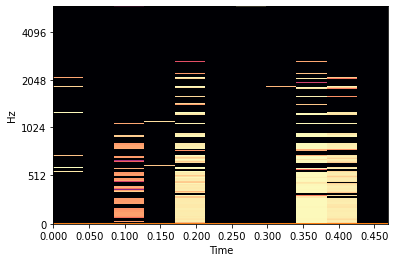

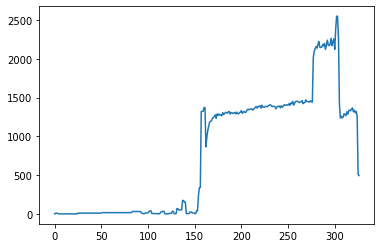

In [343]:
disc_acc = []
gen_loss = [0]
gan_acc = []
while p < 200:
    g_accuracy = 0
    d_accuracy = 0
    print("Step", e)
    e+=1
    if d_accuracy < 1:
        i, o = get_generator_outputs(spectrogram_white_dataset, discriminator_train_size, gan.g, nperseg, spectrogram_clean_dataset)
    gan.block_generator()
    err = evaluate_generator(gan.g, spectrogram_white_dataset, spectrogram_clean_dataset, 100)
    print("Training the discriminator")
    print("Generator error is", err)
    while d_accuracy < 0.9:
        d_accuracy = train_on_batch(gan.d, i, o, verbose=True)
        disc_acc.append(d_accuracy)
        gan_acc.append(0)
        gen_loss.append(err)
    gan.block_discriminator()
    print("Training the generator")
    while g_accuracy < 0.95:
        g_accuracy = train_on_batch(gan.combined_network, spectrogram_white_dataset[:generator_train_size], np.ones(generator_train_size), batch_size=4, verbose=True)
        gan_acc.append(g_accuracy)
        disc_acc.append(0)
        err = evaluate_generator(gan.g, spectrogram_white_dataset, spectrogram_clean_dataset, 100)
        print(err)
        gen_loss.append(err)
        view_output(spectrogram_white_dataset, gan, p)
        p+=1
    #print(evaluate_generator(gan.g, white_dataset, clean_dataset))
plt.plot(disc_acc)
plt.plot(gan_acc)
plt.show()
plt.plot(gen_loss[1:])
plt.show()

#gan.combined_network.save('save4/gan_with_add')

In [344]:
res = []
for i in range(10):
    res.append(hear_output(spectrogram_white_dataset, gan, i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)